In [1]:
# Standard imports
import cv2
import dill as pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# Video creation and viewing imports
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Project imports
from project_utils import *
from vehicle_tracker import VehicleTracker

In [2]:
%matplotlib inline

In [3]:
# If True, will to reload images, recalculate features, and retrain model
# Otherwise, will load from pickled files
RELOAD_ALL = False

Loading pickled training images...
8792 car images, 8968 non-car images, and 3527 hard-negative mined non-car images
Image size: (64, 64, 3) and data type: uint8
6 test images of size: (720, 1280, 3) and data type: uint8


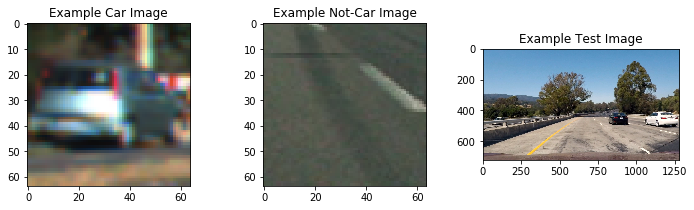

CPU times: user 1.36 s, sys: 1.52 s, total: 2.88 s
Wall time: 1.96 s


In [4]:
%%time
# Load Car, Non-Car, and Test Images from image folders

RELOAD_IMAGES = False

if RELOAD_IMAGES or RELOAD_ALL:
    print('Loading training images from files...')
    image_extensions = ('.png', '.jpg', '.jpeg')
    car_images = list((cv2.imread(file) for file in find_files_generator('../data/vehicles/', image_extensions)))
    noncar_images = list((cv2.imread(file) for file in find_files_generator('../data/non-vehicles/', image_extensions)))
    test_images = list((cv2.imread(file) for file in find_files_generator('../test_images/', image_extensions)))
    hard_negative_images1 = list((cv2.imread(file) for file in find_files_generator('../data/hard-negatives/HardNegatives1/', image_extensions)))
    hard_negative_images2 = list((cv2.imread(file) for file in find_files_generator('../data/hard-negatives/HardNegatives2/', image_extensions)))
    # Pickle files to load faster next time
    to_pickle = [car_images, noncar_images, test_images, hard_negative_images1, hard_negative_images2]
    pickle.dump(to_pickle, open("train_images.pkl", "wb"))
else:
    print('Loading pickled training images...')
    [car_images, noncar_images, test_images, hard_negative_images1, hard_negative_images2] = pickle.load(open("train_images.pkl", "rb"))
    
# Load sample images
car_image = car_images[np.random.randint(0, len(car_images))]
notcar_image = noncar_images[np.random.randint(0, len(noncar_images))]

# Print Basic Characteristics of the Image Datasets
n_cars = len(car_images)
n_noncars = len(noncar_images)
n_hardnegatives = len(hard_negative_images1) + len(hard_negative_images2)
car_img_shape = car_images[0].shape
print('{0} car images, {1} non-car images, and {2} hard-negative mined non-car images'.format(n_cars, n_noncars, n_hardnegatives))
print('Image size: {0} and data type: {1}'.format(car_img_shape, car_images[0].dtype))

n_test_imgs = len(test_images)
test_img_shape = test_images[0].shape
y_img, x_img, _ = test_img_shape
print('{0} test images of size: {1} and data type: {2}'.format(n_test_imgs, test_img_shape, test_images[0].dtype))

# Plot Example Images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
ax1.imshow(BGR2('RGB', car_image))
ax1.set_title('Example Car Image')
ax2.imshow(BGR2('RGB', notcar_image))
ax2.set_title('Example Not-Car Image')
ax3.imshow(BGR2('RGB', test_images[0]))
ax3.set_title('Example Test Image')
plt.show()

In [5]:
# Set Model Parameters

# dataset
test_size = 0.2
rand_state = np.random.randint(0, 100)

# all features
color_space='YUV' # options: BGR, RGB, HSV, LUV, HLS, YUV, YCrCb

# spatial features
spatial_feat = True
spatial_size = (32, 32)

# color features
hist_feat = True
n_hist_bins = 32

# HOG features
hog_feat = True
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = "ALL" # options: 0, 1, 2, or "ALL"

# LinearSVC
C = 0.05

# Window search parameters
y_start = 400
scales = [1, 1.5]
y_stops = [500, 656]

# Heatmap parameters
heat_decay = 0.9
heat_thresh = 10

In [6]:
%%time
# Compute Features and Label Vectors (or load from pickled file)

RELOAD_IMAGE_FEATURES = False

if RELOAD_IMAGE_FEATURES  or RELOAD_ALL:
    print('Extracting and preparing feature and label vectors...')
    # Extract Features
    car_features = extract_features(car_images, color_space=color_space, spatial_size=spatial_size, n_hist_bins=n_hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    noncar_features = extract_features(noncar_images, color_space=color_space, spatial_size=spatial_size, n_hist_bins=n_hist_bins, 
                                       orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    hard_negative_features1 = extract_features(hard_negative_images1, color_space=color_space, spatial_size=spatial_size, n_hist_bins=n_hist_bins, 
                                       orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
    hard_negative_features2 = extract_features(hard_negative_images2, color_space=color_space, spatial_size=spatial_size, n_hist_bins=n_hist_bins, 
                                       orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                       spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

    # Since video is sequential, take first chunk for train, last chunk for test
    hard_negative_features2_train = hard_negative_features2[0:int(len(hard_negative_features2) * (1-test_size))]
    hard_negative_features2_test = hard_negative_features2[int(len(hard_negative_features2) * (1-test_size)):]

    # Create and Scale Feature Vectors
    X = np.vstack((car_features, 
                   noncar_features, 
                   hard_negative_features1)).astype(np.float64)     
    # fit the scaler (sklearn: "for each column, StandardScaler() subtracts the mean and scales by the unit variance")
    scaler = StandardScaler().fit(X)
    # apply scaler to feature vectors 
    X_scaled = scaler.transform(X)

    # Create Labels Vector
    y = np.hstack((np.ones(len(car_features)), 
                   np.zeros(len(noncar_features)), 
                   np.zeros(len(hard_negative_features1))))
    
    # Random Train/Test Split
    split = train_test_split(X_scaled, y, test_size=test_size, random_state=rand_state)
    X_train, X_test, y_train, y_test = split
    
    # Append Non-Random Train/Test Splits
    X_train = np.vstack((X_train, scaler.transform(hard_negative_features2_train)))
    X_test = np.vstack((X_test, scaler.transform(hard_negative_features2_test)))
    y_train = np.hstack((y_train, np.zeros(len(hard_negative_features2_train))))
    y_test = np.hstack((y_test, np.zeros(len(hard_negative_features2_test))))

    to_pickle = [car_features, noncar_features, hard_negative_features1, hard_negative_features2_test, 
                 scaler, X_train, X_test, y_train, y_test]
    pickle.dump(to_pickle, open('train_features.pkl', 'wb'))
else:
    print('Loading pickled feature and label vectors...')
    unpickled = pickle.load(open('train_features.pkl', 'rb'))
    car_features, noncar_features, hard_negative_features1, hard_negative_features2_test, scaler, X_train, X_test, y_train, y_test = unpickled

Loading pickled feature and label vectors...
CPU times: user 391 ms, sys: 2.47 s, total: 2.86 s
Wall time: 2.89 s


In [7]:
# Train a Spatial + HOG Classifier (or load from pickled file)

RETRAIN_CLASSIFIER = False

if RETRAIN_CLASSIFIER or RELOAD_ALL:
    print('Using spatial binning of:', spatial_size, 'and', n_hist_bins, 'histogram bins')
    print('Using:', orient, 'orientations,', pix_per_cell, 'pixels per cell, and', cell_per_block, 'cells per block')
    print('Feature vector length:', len(X_train[0]))

    # create and train an SVC
    print()
    print("Training classifier...")
    svc = LinearSVC(C=C)
    %time svc.fit(X_train, y_train)
    print('Test Accuracy of SVC = {0:.3f}'.format(svc.score(X_test, y_test)))

    n_predict = 1000
    print()
    print('Predicting {0} times:'.format(n_predict))
    %time predictions = list(svc.predict(X_test[0:n_predict]))

    pickle.dump(svc, open('classifier.pkl', 'wb'))
else:
    print('Loading pickled classifier...')
    svc = pickle.load(open('classifier.pkl', 'rb'))
    print('Loaded')

Loading pickled classifier...
Loaded


In [8]:
# Grid Search for finding best parameters

DO_GRID_SEARCH = False

if DO_GRID_SEARCH:
    print([10**num for num in range(-5,6)])
    parameters = {'C':[0.02,0.03,0.04,0.05,0.05,0.07,0.08]}
    print(parameters)
    svr = LinearSVC()
    clf = GridSearchCV(svr, parameters, verbose=1, n_jobs=3)
    clf.fit(X_train, y_train)
    print(clf.best_params_)
    print(clf.best_score_)

In [9]:
# Process video using vehicle tracker pipeline
tracker = VehicleTracker(test_images[0].shape, heat_decay, heat_thresh)
tracker.setup_object_finder(svc, scaler, y_start, y_stops, scales, color_space, 
                            orient, pix_per_cell, cell_per_block, spatial_size, n_hist_bins)

in_video = '/home/dcato/CarND-Advanced-Lane-Lines/test_videos/project_video.mp4'
out_video = './project_video_with_cars.mp4'

clip = VideoFileClip(in_video)
out_clip = clip.fl_image(tracker.process_frame)
%time out_clip.write_videofile(out_video, audio=False)

Ignored exception in /home/dcato/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/moviepy/video/io/ffmpeg_reader.py, around line 259, in ffmpeg_parse_infos
Ignored exception in /home/dcato/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/moviepy/video/io/ffmpeg_reader.py, around line 259, in ffmpeg_parse_infos
[MoviePy] >>>> Building video ./project_video_with_cars.mp4
[MoviePy] Writing video ./project_video_with_cars.mp4


100%|█████████▉| 1260/1261 [16:12<00:00,  1.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_with_cars.mp4 

CPU times: user 16min 18s, sys: 16.5 s, total: 16min 35s
Wall time: 16min 14s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_video))

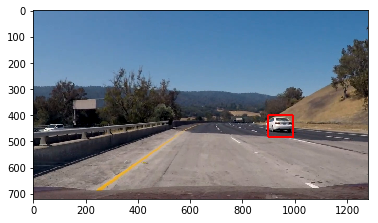

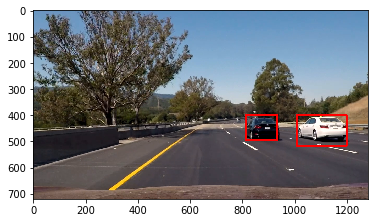

In [26]:
for i, frame in enumerate(tracker.out_frames):
    if i == 600 or i == 967:
        plt.imshow(frame)
        plt.show()